In [61]:
import pandas as pd

In [62]:
# Load the data from a CSV file
df = pd.read_csv('data_football_ratings.csv')

# Display the first few rows of the dataframe
print(df.head())

  competition        date                    match     team  pos pos_role  \
0   Euro 2016  10/06/2016  France - Romania, 2 - 1  Romania   DF       DC   
1   Euro 2016  10/06/2016  France - Romania, 2 - 1  Romania   DF       DC   
2   Euro 2016  10/06/2016  France - Romania, 2 - 1  Romania   DF       DC   
3   Euro 2016  10/06/2016  France - Romania, 2 - 1   France  Sub      Sub   
4   Euro 2016  10/06/2016  France - Romania, 2 - 1  Romania   MF      DMC   

            player      rater  is_human  original_rating  ...  \
0   Dragos Grigore     Kicker         1             3.50  ...   
1   Dragos Grigore  WhoScored         0             6.56  ...   
2   Dragos Grigore  SofaScore         0             6.70  ...   
3  Anthony Martial  WhoScored         0             6.19  ...   
4   Mihai Pintilii     Kicker         1             3.50  ...   

   betweenness_centrality  closeness_centrality  flow_centrality  \
0                0.143055              0.603571         0.304348   
1         

In [63]:
# Count total unique players
total_unique_players = df['player'].nunique()

# Count the number of unique matches per player
matches_per_player = df.groupby('player')['match'].nunique()

# Get players with at least 20 unique matches
players_with_20_matches = matches_per_player[matches_per_player >= 20].index

# Filter the dataframe to keep only these players
df = df[df['player'].isin(players_with_20_matches)].reset_index(drop=True)

top_10_unique_matches = matches_per_player.sort_values(ascending=False).head(10)

# Display results
print(f"Total unique players: {total_unique_players}")
print("Top 10 players with the most unique matches:")
print(top_10_unique_matches)
print(f"Number of players with at least 20 matches: {len(players_with_20_matches)}")

Total unique players: 1632
Top 10 players with the most unique matches:
player
Kevin De Bruyne     48
Hugo Lloris         48
Thibaut Courtois    47
Granit Xhaka        46
Harry Kane          46
Jan Vertonghen      46
Harry Maguire       45
N'Golo Kante        45
David de Gea        45
Romelu Lukaku       45
Name: match, dtype: int64
Number of players with at least 20 matches: 524


In [64]:
# Compute average rating given by each rater
avg_rating_by_rater = df.groupby('rater')['original_rating'].mean().sort_values(ascending=False)
# Display the result
print(avg_rating_by_rater)

# Compute the number of ratings given by each rater
ratings_count_by_rater = df['rater'].value_counts()
# Display the result
print(ratings_count_by_rater)

rater
SofaScore      7.031845
WhoScored      6.840288
TheGuardian    6.413462
SkySports      6.273266
Bild           3.481109
Kicker         3.416547
Name: original_rating, dtype: float64
rater
WhoScored      15337
SkySports       8274
Kicker          6273
Bild            4473
SofaScore        672
TheGuardian      208
Name: count, dtype: int64


In [65]:
# Standardize ratings: for Bild and Kicker, invert the scale so 1 is worst and 10 is best
df['standardized_rating'] = df.apply(
    lambda row: 11 - row['original_rating'] if row['rater'] in ['Bild', 'Kicker'] else row['original_rating'],
    axis=1
)

# Now you can recompute the average rating by each rater using the standardized ratings
avg_standardized_rating_by_rater = df.groupby('rater')['standardized_rating'].mean().sort_values(ascending=False)
print(avg_standardized_rating_by_rater)


rater
Kicker         7.583453
Bild           7.518891
SofaScore      7.031845
WhoScored      6.840288
TheGuardian    6.413462
SkySports      6.273266
Name: standardized_rating, dtype: float64


In [66]:
# Compute the global mean of standardized ratings
global_mean = df['standardized_rating'].mean()

# Compute the mean standardized rating for each rater
rater_means = df.groupby('rater')['standardized_rating'].transform('mean')

# Adjust ratings so each rater has the same mean (the global mean)
df['mean_centered_rating'] = df['standardized_rating'] - rater_means + global_mean

# Check the new means per rater (should all be close to global_mean)
print(df.groupby('rater')['mean_centered_rating'].mean())


rater
Bild           6.926722
Kicker         6.926722
SkySports      6.926722
SofaScore      6.926722
TheGuardian    6.926722
WhoScored      6.926722
Name: mean_centered_rating, dtype: float64


In [ ]:
# Top 10 players by highest average human mean-centered rating
human_best = df[df['is_human'] == 1].groupby('player')['mean_centered_rating'].mean().sort_values(ascending=False).head(10)
print("Top 10 players by highest average human mean-centered rating:")
print(human_best)

# Top 10 players by highest average non-human mean-centered rating
nonhuman_best = df[df['is_human'] == 0].groupby('player')['mean_centered_rating'].mean().sort_values(ascending=False).head(10)
print("\nTop 10 players by highest average non-human mean-centered rating:")
print(nonhuman_best)

# Make mean_centered_rating the new rating of the dataset
df['rating'] = df['mean_centered_rating']

Top 10 players by highest average human mean-centered rating:
player
Kevin De Bruyne     7.905778
Wilfried Zaha       7.867742
David Silva         7.855785
Mohamed Salah       7.805637
Leroy Sane          7.704033
Sven Ulreich        7.656781
Jiri Pavlenka       7.639096
Eden Hazard         7.603217
Andrew Robertson    7.601629
Kingsley Coman      7.577941
Name: mean_centered_rating, dtype: float64

Top 10 players by lowest average human mean-centered rating:
player
Bobby Wood          5.807110
William             6.094067
Levin Oztunali      6.129285
Yuya Osako          6.132346
Joselu              6.153456
Sergio Cordova      6.156181
Milos Jojic         6.180576
Florian Kath        6.269968
Javier Manquillo    6.272504
Divock Origi        6.289721
Name: mean_centered_rating, dtype: float64

Top 10 players by highest average non-human mean-centered rating:
player
Eden Hazard         7.922627
Kevin De Bruyne     7.827499
Sergio Aguero       7.750330
Mohamed Salah       7.682856
Daniel

In [ ]:
# Compute average mean-centered rating for each player by human and non-human raters
human_avg = df[df['is_human'] == 1].groupby('player')['rating'].mean()
nonhuman_avg = df[df['is_human'] == 0].groupby('player')['rating'].mean()

# Join the two series into a DataFrame
rating_diff = pd.DataFrame({
    'human_avg': human_avg,
    'nonhuman_avg': nonhuman_avg
}).dropna()  # Keep only players rated by both

# Compute the absolute difference
rating_diff['abs_diff'] = (rating_diff['human_avg'] - rating_diff['nonhuman_avg']).abs()

# Get the 10 players with the largest difference
top_10_diff = rating_diff.sort_values('abs_diff', ascending=False).head(10)
print("Top 10 players with the most difference between human and non-human ratings:")
print(top_10_diff)

Top 10 players with the most difference between human and non-human ratings:
                   human_avg  nonhuman_avg  abs_diff
player                                              
Sven Ulreich        7.656781      6.749648  0.907133
William             6.094067      6.992343  0.898276
Lukas Hradecky      7.432136      6.572371  0.859765
Peter Gulacsi       7.493260      6.655828  0.837432
Rune Jarstein       7.419040      6.639192  0.779848
Philipp Tschauner   7.381222      6.607434  0.773789
Nico Schulz         7.526534      6.829026  0.697508
Jiri Pavlenka       7.639096      6.951888  0.687208
Bernd Leno          7.334186      6.647371  0.686815
Joselu              6.153456      6.830100  0.676644


In [73]:
# For each player's match, compute the average human and non-human rating using 'rating' (which is mean_centered_rating)

# Group by player, match, and is_human, then average the rating
grouped = df.groupby(['player', 'match', 'is_human'])['rating'].mean().reset_index()

# Pivot so each row is a player-match, with columns for human and non-human ratings
pivoted = grouped.pivot(index=['player', 'match'], columns='is_human', values='rating').reset_index()
pivoted = pivoted.rename(columns={0: 'non_human_rating', 1: 'human_rating'})

pivoted.to_csv('player_match_ratings.csv', index=False)

Text(0, 0.5, 'Mean-centered Rating')

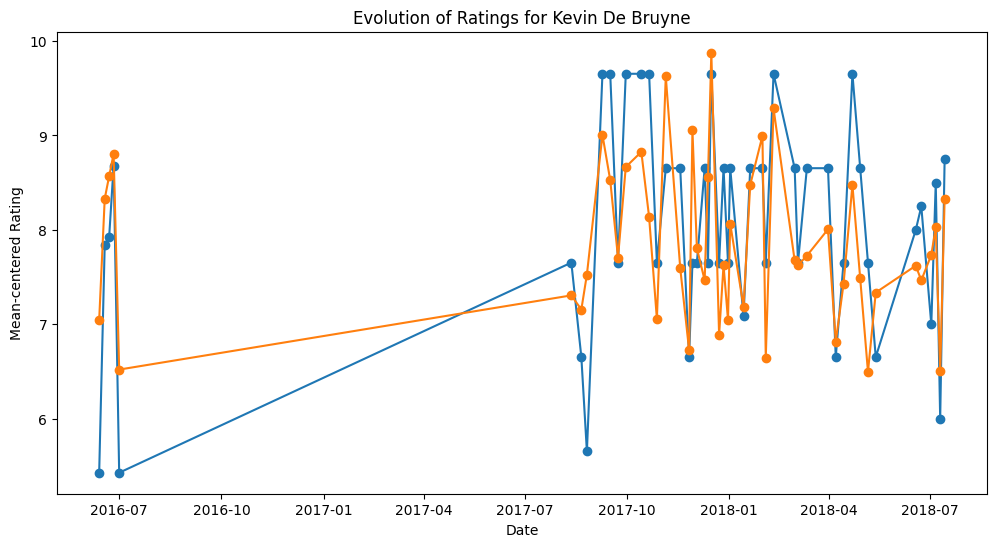

In [75]:
import matplotlib.pyplot as plt

# Filter for Kevin De Bruyne
kevin = final[final['player'] == 'Kevin De Bruyne'].copy()

# Convert date to datetime
kevin['date'] = pd.to_datetime(kevin['date'], dayfirst=True)

# Sort by date
kevin = kevin.sort_values('date')

# Plot
plt.figure(figsize=(12, 6))
plt.plot(kevin['date'], kevin['human_rating'], marker='o', label='Human rating')
plt.plot(kevin['date'], kevin['non_human_rating'], marker='o', label='Non-human rating')
plt.title('Evolution of Ratings for Kevin De Bruyne')
plt.xlabel('Date')
plt.ylabel('Mean-centered Rating')

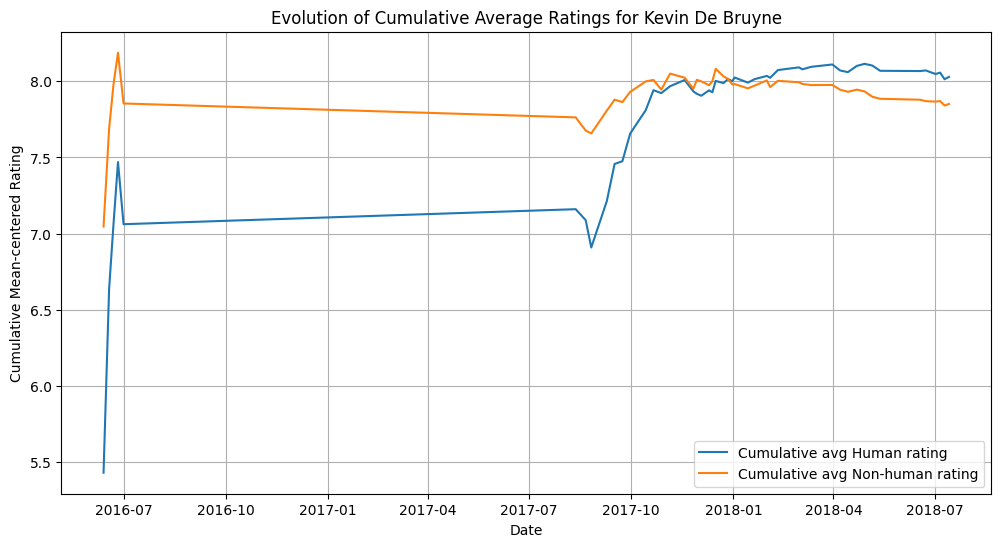

In [77]:
import matplotlib.pyplot as plt

# Filter for Kevin De Bruyne
kevin = final[final['player'] == 'Kevin De Bruyne'].copy()

# Convert date to datetime
kevin['date'] = pd.to_datetime(kevin['date'], dayfirst=True)

# Sort by date
kevin = kevin.sort_values('date')

# Compute cumulative average for human and non-human ratings
kevin['cumavg_human'] = kevin['human_rating'].expanding().mean()
kevin['cumavg_nonhuman'] = kevin['non_human_rating'].expanding().mean()

# Plot with continuous lines (no markers)
plt.figure(figsize=(12, 6))
plt.plot(kevin['date'], kevin['cumavg_human'], label='Cumulative avg Human rating')
plt.plot(kevin['date'], kevin['cumavg_nonhuman'], label='Cumulative avg Non-human rating')
plt.title('Evolution of Cumulative Average Ratings for Kevin De Bruyne')
plt.xlabel('Date')
plt.ylabel('Cumulative Mean-centered Rating')
plt.legend()
plt.grid(True)